In [30]:
import numpy as np
from collections import Counter
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from scipy.stats import entropy
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [31]:
# Φόρτωση δεδομένων imdb
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=20000)

# Διαχωρισμός 80% train - 20% dev
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

word_index = keras.datasets.imdb.get_word_index(path="imdb_word_index.json")
# Offset διόρθωση στα indices
word_index = {k: (v + 3) for k, v in word_index.items()}  
inverted_word_index = {v: k for k, v in word_index.items()}

def filtered_index(n=1000, k=1000):
    """Αφαίρεση των n πιο συχνών και k πιο σπάνιων λέξεων από το λεξικό"""
    # Δημιουργία λεξικού συχνότητας λέξεων
    word_counts = Counter()
    for sequence in x_train:
        word_counts.update(sequence)
    
    # Ταξινόμηση λέξεων με βάση τη συχνότητα (φθίνουσα σειρά)
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # Αφαίρεση των n πιο συχνών και k πιο σπάνιων λέξεων
    if k > 0:
        filtered_words = sorted_words[n:-k]
    else:
        filtered_words = sorted_words[n:]

    filtered_word_ids = {word_id for word_id, _ in filtered_words}

    # Φιλτράρισμα του λεξικού ώστε να περιέχει ΜΟΝΟ τις επιτρεπτές λέξεις
    filter_index = {word_id: inverted_word_index[word_id] 
                    for word_id in filtered_word_ids 
                    if word_id in inverted_word_index}

    # Εκτυπώσεις για debugging
    print(f"Λέξεις στο αρχικό λεξικό: {len(inverted_word_index)}")
    print(f"Λέξεις μετά το φιλτράρισμα: {len(filter_index)}")
    print(f"Μέγιστο index στο filter_index: {max(filter_index.keys(), default=0)}")
    print(f"Μερικά στοιχεία από το filter_index: {list(filter_index.items())[:10]}")

    return filter_index

filter_index = filtered_index(n=1000, k=100)

Λέξεις στο αρχικό λεξικό: 88584
Λέξεις μετά το φιλτράρισμα: 18893
Μέγιστο index στο filter_index: 19999
Μερικά στοιχεία από το filter_index: [(967, 'rate'), (978, 'background'), (989, 'break'), (992, 'gay'), (996, 'fails'), (999, 'era'), (1001, 'co'), (1004, 'inside'), (1005, 'outside'), (1006, 'nudity')]


In [32]:
unique_x_train_indices = set(np.concatenate(x_train))
print(f"Μέγιστο index στο x_train: {max(unique_x_train_indices)}")
print(f"Μέγιστο index στο filter_index: {max(filter_index.keys())}")
common_indices = unique_x_train_indices & set(filter_index.keys())
print(f"Κοινά indices μεταξύ x_train και filter_index: {len(common_indices)}")

Μέγιστο index στο x_train: 19999
Μέγιστο index στο filter_index: 19999
Κοινά indices μεταξύ x_train και filter_index: 18893


In [33]:
def best_ig_index(x_train, y_train, filtered_index, m=100):
    """
    Υπολογίζει το Information Gain για τις λέξεις στο filtered_index
    και επιστρέφει τις m καλύτερες.

    :param x_train: Φιλτραρισμένες κριτικές (λίστα από λίστες με word indices)
    :param y_train: Labels (0 = αρνητική, 1 = θετική)
    :param filtered_index: Λεξικό {word_id: word} με τις λέξεις που θα χρησιμοποιηθούν
    :param m: Πλήθος κορυφαίων λέξεων που θα επιστραφούν
    :return: Λεξικό {word: IG} με τις m λέξεις με το μεγαλύτερο IG
    """

    # Μετατροπή labels σε numpy array
    y_train = np.array(y_train)
    total_samples = len(y_train)

    # Υπολογισμός αρχικής εντροπίας H(Y)
    p_positive = np.mean(y_train)  
    p_negative = 1 - p_positive
    H_Y = entropy([p_positive, p_negative], base=2)

    # Μέτρηση εμφανίσεων μόνο για τις λέξεις του filtered_index
    word_counts_pos = Counter()
    word_counts_neg = Counter()
    word_appearances = Counter()

    for review, label in zip(x_train, y_train):
        unique_words = set(review) & set(filtered_index.keys())  # Κρατάμε μόνο τις φιλτραρισμένες λέξεις
        for word in unique_words:
            word_appearances[word] += 1
            if label == 1:
                word_counts_pos[word] += 1
            else:
                word_counts_neg[word] += 1

    # Δημιουργία DataFrame για ταχύτητα
    df = pd.DataFrame({
        'word_id': list(word_appearances.keys()),
        'appearances': list(word_appearances.values()),
        'pos_count': [word_counts_pos[w] for w in word_appearances.keys()],
        'neg_count': [word_counts_neg[w] for w in word_appearances.keys()]
    })

    # Υπολογισμός πιθανοτήτων P(w = 1) και P(w = 0)
    df['P_w'] = df['appearances'] / total_samples
    df['P_not_w'] = 1 - df['P_w']

    # Υπολογισμός H(Y | w = 1)
    df['P_pos_given_w'] = df['pos_count'] / df['appearances']
    df['P_neg_given_w'] = df['neg_count'] / df['appearances']
    df['H_Y_given_w'] = entropy(np.c_[df['P_pos_given_w'], df['P_neg_given_w']], axis=1, base=2)

    # Υπολογισμός H(Y | w = 0)
    count_pos_not_w = p_positive * total_samples - df['pos_count']
    count_neg_not_w = p_negative * total_samples - df['neg_count']
    count_not_w = total_samples - df['appearances']

    df['P_pos_given_not_w'] = count_pos_not_w / count_not_w
    df['P_neg_given_not_w'] = count_neg_not_w / count_not_w
    df['H_Y_given_not_w'] = entropy(np.c_[df['P_pos_given_not_w'], df['P_neg_given_not_w']], axis=1, base=2)

    # Υπολογισμός Information Gain
    df['IG'] = H_Y - (df['P_w'] * df['H_Y_given_w'] + df['P_not_w'] * df['H_Y_given_not_w'])

    # Αντιστοίχιση word_id σε actual λέξη
    df['word'] = df['word_id'].map(filtered_index)

    # Ταξινόμηση κατά IG και επιλογή των κορυφαίων m λέξεων
    df = df.sort_values(by='IG', ascending=False).head(m)

    # Επιστροφή ως λεξικό {word: IG}
    print("Τελικές top IG words:", list(df[['word', 'IG']].itertuples(index=False))[:10])
    return dict(zip(df['word'], df['IG']))

top_ig_index = best_ig_index(x_train, y_train, filter_index, m=100)
print(top_ig_index)

Τελικές top IG words: [Pandas(word='pointless', IG=0.010863362937456822), Pandas(word='wasted', IG=0.009038705680905701), Pandas(word='laughable', IG=0.008682102850446904), Pandas(word='redeeming', IG=0.007679096558540155), Pandas(word='beautifully', IG=0.007276318344682897), Pandas(word='pathetic', IG=0.006933782282477097), Pandas(word='unfunny', IG=0.006787799147807139), Pandas(word='fails', IG=0.006608274203727338), Pandas(word='garbage', IG=0.00653844383585267), Pandas(word='touching', IG=0.006190332521601505)]
{'pointless': 0.010863362937456822, 'wasted': 0.009038705680905701, 'laughable': 0.008682102850446904, 'redeeming': 0.007679096558540155, 'beautifully': 0.007276318344682897, 'pathetic': 0.006933782282477097, 'unfunny': 0.006787799147807139, 'fails': 0.006608274203727338, 'garbage': 0.00653844383585267, 'touching': 0.006190332521601505, 'wonderfully': 0.0059948226571829855, 'outstanding': 0.005635394252890724, 'wooden': 0.0047811172567499005, 'excuse': 0.004701899582919222, 

In [34]:
# Αντιστροφή filtered_index {word: word_id}
word_to_id = {word: word_id for word_id, word in filter_index.items()}
print(word_to_id)

sorted_ig_words = sorted(top_ig_index.items(), key=lambda x: word_to_id[x[0]])
indice_ig_dict = {word_to_id[word]: IG for word, IG in sorted_ig_words[:1000]}

print(f"Μέγιστο index στο indice_ig_dict: {max(indice_ig_dict.keys())}")
print(f"Κοινά indices μεταξύ x_train και indice_ig_dict: {set(np.concatenate(x_train)) & set(indice_ig_dict.keys())}")

{'rate': 967, 'background': 978, 'break': 989, 'gay': 992, 'fails': 996, 'era': 999, 'co': 1001, 'inside': 1004, 'outside': 1005, 'nudity': 1006, 'reasons': 1007, 'ideas': 1008, 'twist': 1009, 'western': 1010, 'front': 1011, 'match': 1014, 'fairly': 1018, 'villain': 1019, 'talented': 1020, 'married': 1021, 'ben': 1022, 'success': 1023, 'william': 1024, 'unlike': 1025, 'rich': 1026, 'attempts': 1027, 'spoilers': 1028, 'list': 1029, 'manages': 1030, 'social': 1031, 'odd': 1032, 'recently': 1033, 'remake': 1034, 'flat': 1035, 'cute': 1036, 'further': 1037, 'sadly': 1038, 'copy': 1039, 'wrote': 1040, 'agree': 1041, 'doctor': 1042, 'cold': 1043, 'plain': 1044, 'following': 1045, 'mentioned': 1046, 'sweet': 1047, 'incredible': 1048, 'missed': 1049, 'pure': 1050, 'crew': 1051, 'office': 1052, 'wasted': 1053, 'ended': 1054, 'produced': 1055, 'gun': 1056, 'filmmakers': 1057, 'large': 1058, 'caught': 1059, 'revenge': 1060, 'filled': 1061, 'pace': 1062, 'popular': 1063, 'waiting': 1064, "'the": 1

In [35]:
def vectorized_data(data, index, m=100):
    """
    Μετατρέπει τις κριτικές σε δυαδική αναπαράσταση (0/1) με βάση τις κορυφαίες m λέξεις (indices).

    :param data: Λίστα από κριτικές (λίστα από λίστες με word indices)
    :param index: Λεξικό {word_index: IG} με τις καλύτερες λέξεις (indices)
    :param m: Αριθμός των κορυφαίων λέξεων που θα χρησιμοποιηθούν
    :return: np.array διαστάσεων (len(data), m) με 0 και 1
    """

    # Επιλογή των m πιο διαχωριστικών λέξεων με βάση το Information Gain
    top_word_indices = list(index.keys())[:m]
    word_to_idx = {word: i for i, word in enumerate(top_word_indices)}

    # Δημιουργία πίνακα NumPy (samples x m)
    binary_matrix = np.zeros((len(data), m), dtype=int)

    for i, review in enumerate(data):  # Κάθε review είναι λίστα από word indices
        for word_index in review:
            if word_index in word_to_idx:
                binary_matrix[i, word_to_idx[word_index]] = 1

    return binary_matrix

# Παράδειγμα χρήσης
# x_train: Οι κριτικές με indices 
train_vector = vectorized_data(x_train, indice_ig_dict, m=100)
print(train_vector.shape)  # (len(x_train), m)
print(train_vector)  # Μήτρα με 0 και 1
print(f"Μοναδικές τιμές στο train_vector: {np.unique(train_vector)}")

(20000, 100)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Μοναδικές τιμές στο train_vector: [0 1]


In [36]:
def decision_stump_train(X, y, sample_weights):
    """
    Εκπαιδεύει έναν Decision Stump χρησιμοποιώντας σταθμισμένη ταξινόμηση.

    :param X: Δεδομένα εισόδου (samples, features) (numpy array)
    :param y: Ετικέτες (-1 ή 1) (numpy array)
    :param sample_weights: Σταθμίσεις δειγμάτων (numpy array)
    :return: Λεξικό με τις παραμέτρους του βέλτιστου stump
    """
    n_samples, n_features = X.shape
    best_feature, best_threshold, best_polarity = None, None, None
    best_error = float('inf')

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])  # Δοκιμή για όλα τα μοναδικά thresholds

        for threshold in thresholds:
            for polarity in [1, -1]:
                predictions = np.ones(n_samples)
                if polarity == 1:
                    predictions[X[:, feature] < threshold] = -1
                else:
                    predictions[X[:, feature] >= threshold] = -1

                error = np.sum(sample_weights * (predictions != y))

                if error < best_error:
                    best_error = error
                    best_feature = feature
                    best_threshold = threshold
                    best_polarity = polarity

    return {
        'feature': best_feature,
        'threshold': best_threshold,
        'polarity': best_polarity
    }

In [37]:
def decision_stump_predict(X, stump):
    """
    Κάνει predict χρησιμοποιώντας έναν εκπαιδευμένο decision stump.

    :param X: Δεδομένα εισόδου (samples, features)
    :param stump: Το μοντέλο (dict με feature, threshold, polarity)
    :return: Προβλέψεις (-1 ή 1)
    """
    feature = stump['feature']
    threshold = stump['threshold']
    polarity = stump['polarity']

    predictions = np.ones(X.shape[0])
    if polarity == 1:
        predictions[X[:, feature] < threshold] = -1
    else:
        predictions[X[:, feature] >= threshold] = -1

    return predictions

In [38]:
def adaboost_train(X, y, T=50, error_threshold=1e-3):
    """
    Εκπαίδευση του AdaBoost με decision stumps.

    :param X: Δεδομένα εισόδου (samples, features)
    :param y: Ετικέτες (-1 ή 1)
    :param T: Μέγιστος αριθμός επαναλήψεων
    :param error_threshold: Κατώφλι σφάλματος για πρόωρη διακοπή
    :return: Λίστα από (stump, weight)
    """
    n_samples = X.shape[0]
    sample_weights = np.ones(n_samples) / n_samples
    classifiers = []

    for t in range(T):
        stump = decision_stump_train(X, y, sample_weights)
        predictions = decision_stump_predict(X, stump)

        error = np.sum(sample_weights * (predictions != y)) / np.sum(sample_weights)

        # Αν το error είναι 0 ή πολύ μικρό, σταματάμε
        if error < error_threshold:
            break

        # Υπολογισμός του αλφα (βάρος του stump)
        alpha = 0.5 * np.log((1 - error) / (error + 1e-10))

        # Ενημέρωση βαρών
        sample_weights *= np.exp(-alpha * y * predictions)
        sample_weights /= np.sum(sample_weights)  # Κανονικοποίηση

        # Αποθήκευση stump και weight
        classifiers.append((stump, alpha))

    return classifiers

In [39]:
def adaboost_predict(X, classifiers):
    """
    Πρόβλεψη με τον εκπαιδευμένο AdaBoost.

    :param X: Δεδομένα εισόδου (samples, features)
    :param classifiers: Λίστα από (stump, weight)
    :return: Προβλέψεις (-1 ή 1)
    """
    final_prediction = np.zeros(X.shape[0])

    for stump, alpha in classifiers:
        final_prediction += alpha * decision_stump_predict(X, stump)

    return np.sign(final_prediction)

In [40]:
def evaluate_metrics(y_true, y_pred):
    """
    Υπολογίζει precision, recall, F1-score για τις δύο κλάσεις και τα macro/micro averages.
    :param y_true: Πραγματικές τιμές
    :param y_pred: Προβλέψεις μοντέλου
    :return: Λεξικό με τα precision, recall, F1
    """
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)

    return {
        "class_0": {"precision": precision[0], "recall": recall[0], "f1": f1[0]},
        "class_1": {"precision": precision[1], "recall": recall[1], "f1": f1[1]},
        "macro_avg": {"precision": macro_precision, "recall": macro_recall, "f1": macro_f1},
        "micro_avg": {"precision": micro_precision, "recall": micro_recall, "f1": micro_f1},
    }


In [41]:

def print_evaluation_results(metrics, dataset_name):
    """
    Εκτυπώνει τα αποτελέσματα αξιολόγησης για ένα συγκεκριμένο dataset.
    :param metrics: Μετρικές αξιολόγησης
    :param dataset_name: Όνομα του dataset (Train, Dev, Test)
    """
    print(f"\n{dataset_name} Set:")
    for key, values in metrics.items():
        print(f"{key}: Precision={values['precision']:.4f}, Recall={values['recall']:.4f}, F1={values['f1']:.4f}")


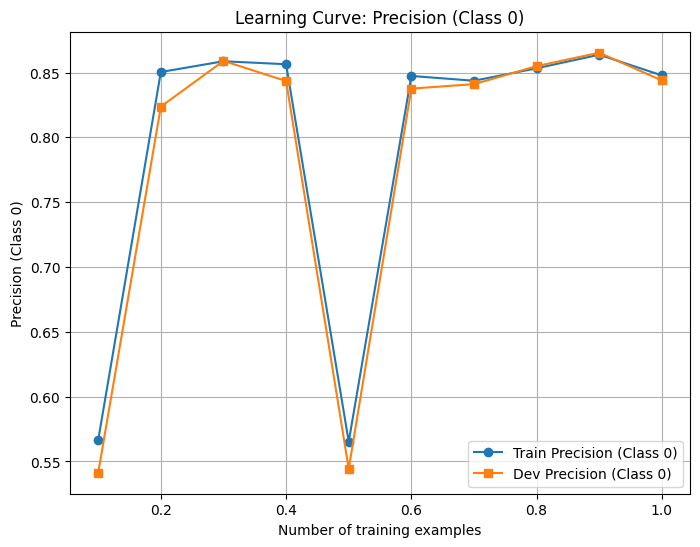

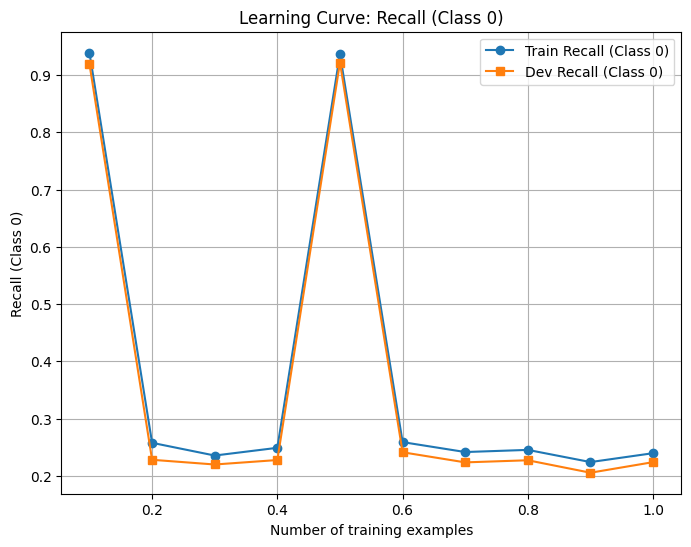

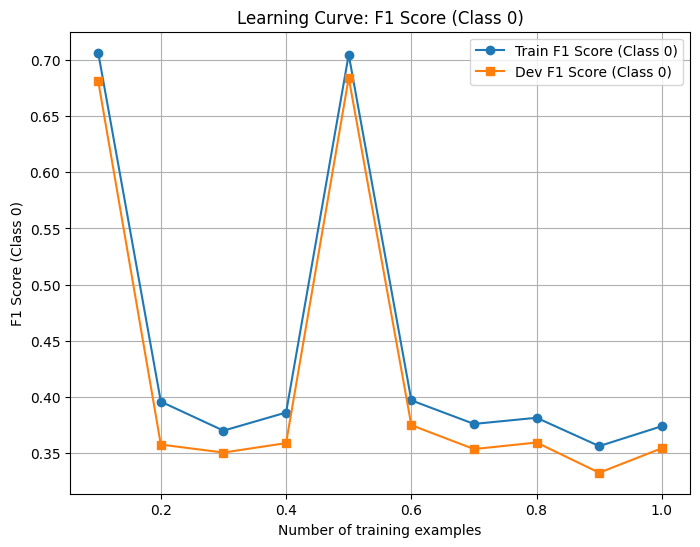


--- My AdaBoost Evaluation ---

Train Set:
class_0: Precision=0.8478, Recall=0.2397, F1=0.3737
class_1: Precision=0.5540, Recall=0.9564, F1=0.7016
macro_avg: Precision=0.7009, Recall=0.5981, F1=0.5377
micro_avg: Precision=0.5958, Recall=0.5958, F1=0.5958

Dev Set:
class_0: Precision=0.8439, Recall=0.2240, F1=0.3541
class_1: Precision=0.5656, Recall=0.9606, F1=0.7120
macro_avg: Precision=0.7047, Recall=0.5923, F1=0.5330
micro_avg: Precision=0.6016, Recall=0.6016, F1=0.6016

Test Set:
class_0: Precision=0.8439, Recall=0.2366, F1=0.3696
class_1: Precision=0.5561, Recall=0.9562, F1=0.7032
macro_avg: Precision=0.7000, Recall=0.5964, F1=0.5364
micro_avg: Precision=0.5964, Recall=0.5964, F1=0.5964


In [44]:

def plot_learning_curves(train_sizes, train_scores, dev_scores, metric_name):
    """
    Σχεδιάζει τις καμπύλες μάθησης για precision, recall, F1-score.
    :param train_sizes: Λίστα μεγεθών εκπαίδευσης
    :param train_scores: Λίστα τιμών για το train set
    :param dev_scores: Λίστα τιμών για το dev set
    :param metric_name: Όνομα μετρικής
    """
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores, label=f"Train {metric_name}", marker='o')
    plt.plot(train_sizes, dev_scores, label=f"Dev {metric_name}", marker='s')
    plt.xlabel("Number of training examples")
    plt.ylabel(metric_name)
    plt.title(f"Learning Curve: {metric_name}")
    plt.legend()
    plt.grid()
    plt.show()

# Μετατροπή των labels από {0,1} -> {-1,1} για AdaBoost
y_train_boost = np.where(np.array(y_train) == 0, -1, 1)
y_dev_boost = np.where(np.array(y_dev) == 0, -1, 1)
y_test_boost = np.where(np.array(y_test) == 0, -1, 1)

# Διαφορετικά ποσοστά εκπαίδευσης
train_sizes = np.linspace(0.1, 1.0, 10)  # Από 10% έως 100%
train_precision, train_recall, train_f1 = [], [], []
dev_precision, dev_recall, dev_f1 = [], [], []

for size in train_sizes:
    sample_size = int(size * len(x_train))
    X_train_subset, y_train_subset = train_vector[:sample_size], y_train_boost[:sample_size]

    # Εκπαίδευση AdaBoost
    classifiers = adaboost_train(X_train_subset, y_train_subset, T=50)

    # Αξιολόγηση σε train και dev
    y_train_pred = adaboost_predict(X_train_subset, classifiers)
    y_dev_pred = adaboost_predict(vectorized_data(x_dev, indice_ig_dict, m=100), classifiers)

    train_metrics = evaluate_metrics(y_train_subset, y_train_pred)
    dev_metrics = evaluate_metrics(y_dev_boost, y_dev_pred)

    train_precision.append(train_metrics["class_0"]["precision"])
    train_recall.append(train_metrics["class_0"]["recall"])
    train_f1.append(train_metrics["class_0"]["f1"])

    dev_precision.append(dev_metrics["class_0"]["precision"])
    dev_recall.append(dev_metrics["class_0"]["recall"])
    dev_f1.append(dev_metrics["class_0"]["f1"])

# Σχεδίαση καμπυλών μάθησης
plot_learning_curves(train_sizes, train_precision, dev_precision, "Precision (Class 0)")
plot_learning_curves(train_sizes, train_recall, dev_recall, "Recall (Class 0)")
plot_learning_curves(train_sizes, train_f1, dev_f1, "F1 Score (Class 0)")

# --- Αξιολόγηση στο πλήρες Train Set ---
X_train_vectorized = train_vector
y_train_pred_full = adaboost_predict(X_train_vectorized, classifiers)
train_metrics_full = evaluate_metrics(y_train_boost, y_train_pred_full)

# --- Αξιολόγηση στο Dev Set ---
X_dev_vectorized = vectorized_data(x_dev, indice_ig_dict, m=100)
y_dev_pred_full = adaboost_predict(X_dev_vectorized, classifiers)
dev_metrics_full = evaluate_metrics(y_dev_boost, y_dev_pred_full)

# --- Αξιολόγηση στο Test Set ---
X_test_vectorized = vectorized_data(x_test, indice_ig_dict, m=100)
y_test_pred = adaboost_predict(X_test_vectorized, classifiers)
test_metrics = evaluate_metrics(y_test_boost, y_test_pred)

# --- Εκτύπωση αποτελεσμάτων ---
print("\n--- My AdaBoost Evaluation ---")
print_evaluation_results(train_metrics_full, "Train")
print_evaluation_results(dev_metrics_full, "Dev")
print_evaluation_results(test_metrics, "Test")


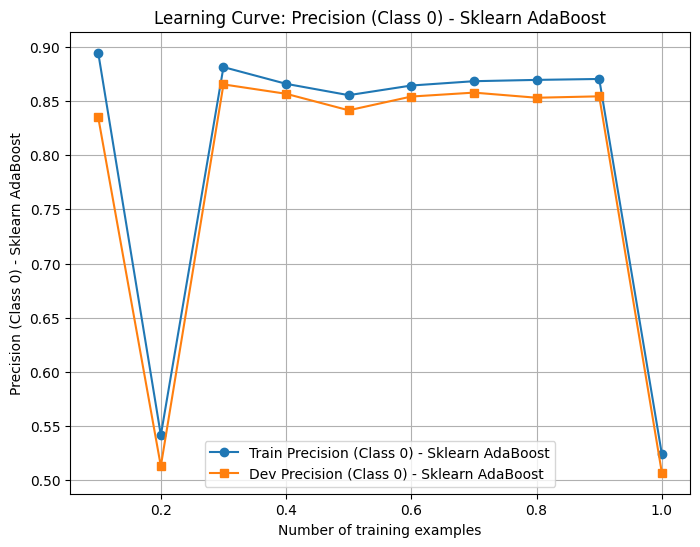

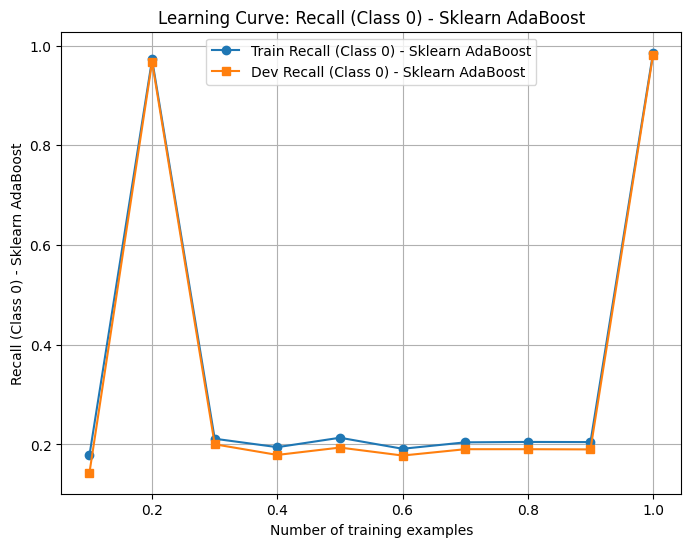

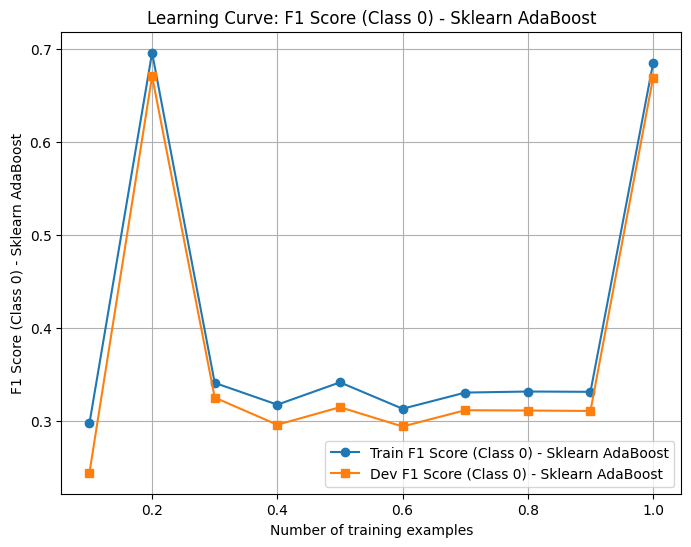


--- Sklearn AdaBoost Evaluation ---
Train Set:
class_0: Precision=0.5241, Recall=0.9859, F1=0.6844
class_1: Precision=0.8675, Recall=0.0936, F1=0.1690
macro_avg: Precision=0.6958, Recall=0.5397, F1=0.4267
micro_avg: Precision=0.5425, Recall=0.5425, F1=0.5425

Dev Set:
class_0: Precision=0.5070, Recall=0.9819, F1=0.6687
class_1: Precision=0.8429, Recall=0.0921, F1=0.1660
macro_avg: Precision=0.6749, Recall=0.5370, F1=0.4174
micro_avg: Precision=0.5258, Recall=0.5258, F1=0.5258

Test Set:
class_0: Precision=0.5193, Recall=0.9870, F1=0.6805
class_1: Precision=0.8687, Recall=0.0862, F1=0.1569
macro_avg: Precision=0.6940, Recall=0.5366, F1=0.4187
micro_avg: Precision=0.5366, Recall=0.5366, F1=0.5366


In [ ]:
# --- Ετοιμη υλοποίηση AdaBoost ---
# Μετατροπή των labels από {-1,1} -> {0,1} για sklearn
y_train_sklearn = np.where(y_train_boost == -1, 0, 1)
y_dev_sklearn = np.where(y_dev_boost == -1, 0, 1)
y_test_sklearn = np.where(y_test_boost == -1, 0, 1)

# Εκπαίδευση του AdaBoost με sklearn
sklearn_adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42
)
sklearn_adaboost.fit(train_vector, y_train_sklearn)

# Αξιολόγηση σε train και dev
y_train_pred_sklearn = sklearn_adaboost.predict(train_vector)
y_dev_pred_sklearn = sklearn_adaboost.predict(vectorized_data(x_dev, indice_ig_dict, m=100))

train_metrics_sklearn = evaluate_metrics(y_train_sklearn, y_train_pred_sklearn)
dev_metrics_sklearn = evaluate_metrics(y_dev_sklearn, y_dev_pred_sklearn)

# Διαφορετικά ποσοστά εκπαίδευσης
train_sizes = np.linspace(0.1, 1.0, 10)  # Από 10% έως 100%
train_precision_sklearn, train_recall_sklearn, train_f1_sklearn = [], [], []
dev_precision_sklearn, dev_recall_sklearn, dev_f1_sklearn = [], [], []

for size in train_sizes:
    sample_size = int(size * len(x_train))
    X_train_subset, y_train_subset = train_vector[:sample_size], y_train_sklearn[:sample_size]

    # Εκπαίδευση του AdaBoost με sklearn
    sklearn_adaboost = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=50,
        random_state=42
    )
    sklearn_adaboost.fit(X_train_subset, y_train_subset)

    # Αξιολόγηση σε train και dev
    y_train_pred_sklearn = sklearn_adaboost.predict(X_train_subset)
    y_dev_pred_sklearn = sklearn_adaboost.predict(vectorized_data(x_dev, indice_ig_dict, m=100))

    train_metrics_sklearn = evaluate_metrics(y_train_subset, y_train_pred_sklearn)
    dev_metrics_sklearn = evaluate_metrics(y_dev_sklearn, y_dev_pred_sklearn)

    train_precision_sklearn.append(train_metrics_sklearn["class_0"]["precision"])
    train_recall_sklearn.append(train_metrics_sklearn["class_0"]["recall"])
    train_f1_sklearn.append(train_metrics_sklearn["class_0"]["f1"])

    dev_precision_sklearn.append(dev_metrics_sklearn["class_0"]["precision"])
    dev_recall_sklearn.append(dev_metrics_sklearn["class_0"]["recall"])
    dev_f1_sklearn.append(dev_metrics_sklearn["class_0"]["f1"])

# Σχεδίαση καμπυλών μάθησης
plot_learning_curves(train_sizes, train_precision_sklearn, dev_precision_sklearn, "Precision (Class 0) - Sklearn AdaBoost")
plot_learning_curves(train_sizes, train_recall_sklearn, dev_recall_sklearn, "Recall (Class 0) - Sklearn AdaBoost")
plot_learning_curves(train_sizes, train_f1_sklearn, dev_f1_sklearn, "F1 Score (Class 0) - Sklearn AdaBoost")

# Εμφάνιση αποτελεσμάτων
print("\n--- Sklearn AdaBoost Evaluation ---")
print("Train Set:")
for key, values in train_metrics_sklearn.items():
    print(f"{key}: Precision={values['precision']:.4f}, Recall={values['recall']:.4f}, F1={values['f1']:.4f}")

print("\nDev Set:")
for key, values in dev_metrics_sklearn.items():
    print(f"{key}: Precision={values['precision']:.4f}, Recall={values['recall']:.4f}, F1={values['f1']:.4f}")

# Αξιολόγηση σε x_test
y_test_pred_sklearn = sklearn_adaboost.predict(X_test_vectorized)
test_metrics_sklearn = evaluate_metrics(y_test_sklearn, y_test_pred_sklearn)

print("\nTest Set:")
for key, values in test_metrics_sklearn.items():
    print(f"{key}: Precision={values['precision']:.4f}, Recall={values['recall']:.4f}, F1={values['f1']:.4f}")